In [92]:
import os
import pandas as pd
import numpy as np
import librosa
from librosa.core import resample, to_mono
import wavio
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from jupyterthemes import jtplot

In [93]:
jtplot.style(theme='onedork', context='talk', gridlines='--')

In [94]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [95]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [96]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [97]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [106]:
rootFolder = "bird_data"
wavFolder = os.path.join(rootFolder, "wav_files")
bird_calls_df = pd.read_csv(os.path.join(rootFolder, "bird_calls.csv"))

In [107]:
bird_calls_df.head()

,fname,label
0,American_Goldfinch_XC114342.wav,American_Goldfinch
1,American_Goldfinch_XC124312.wav,American_Goldfinch
2,American_Goldfinch_XC133564.wav,American_Goldfinch
3,American_Goldfinch_XC133565.wav,American_Goldfinch
4,American_Goldfinch_XC141469.wav,American_Goldfinch


# Class inbalance

In [108]:
bird_calls_df.set_index('fname', inplace=True)

In [109]:
# add column with the length of the signal in seconds
for f in bird_calls_df.index:
    rate, signal = wavfile.read(os.path.join(wavFolder,f))
    bird_calls_df.at[f, "length"] = signal.shape[0]/rate

In [110]:
bird_calls_df.head()

,label,length
fname,,
American_Goldfinch_XC114342.wav,American_Goldfinch,136.968375
American_Goldfinch_XC124312.wav,American_Goldfinch,52.920000
American_Goldfinch_XC133564.wav,American_Goldfinch,50.599184
American_Goldfinch_XC133565.wav,American_Goldfinch,55.222857
American_Goldfinch_XC141469.wav,American_Goldfinch,54.058934


In [111]:
bird_classes = list(np.unique(bird_calls_df.label))

In [112]:
bird_classes_distribution = bird_calls_df.groupby(['label'])['length'].mean()

In [113]:
bird_classes_distribution

label
American_Goldfinch        52.322228
American_Robin            75.790837
Barn_Swallow             132.134248
Blue-grey_Gnatcatcher     60.431434
Blue_Jay                  49.986092
Carolina_Chickadee        56.634403
Carolina_Wren             50.195712
Cedar_Waxwing             39.937296
Northern_Cardinal         66.524785
Ruby-crowned_Kinglet      52.924116
Name: length, dtype: float64

In [114]:
def hbarplot(data, xlabel, title):
    fig, ax = plt.subplots()
    ax.barh(data.index, data)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

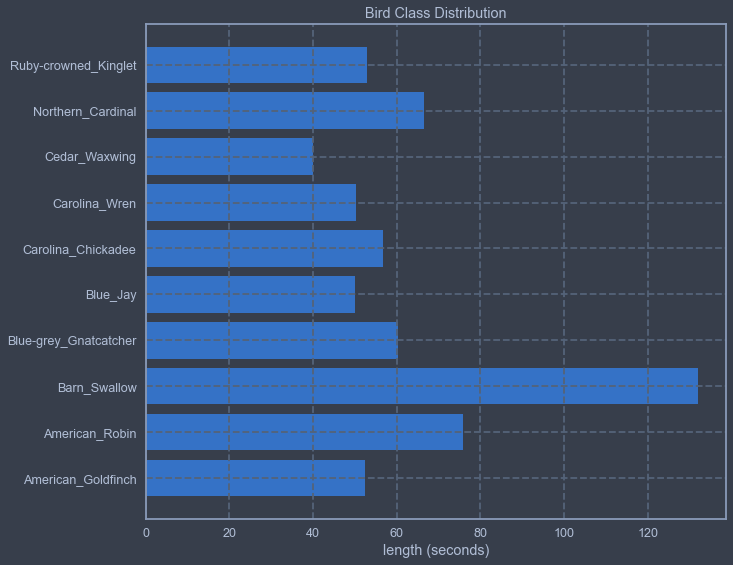

In [115]:
hbarplot(bird_classes_distribution, "length (seconds)", "Bird Class Distribution")

In [116]:
bird_calls_df.reset_index(inplace=True)
bird_calls_df.head()

,fname,label,length
0,American_Goldfinch_XC114342.wav,American_Goldfinch,136.968375
1,American_Goldfinch_XC124312.wav,American_Goldfinch,52.920000
2,American_Goldfinch_XC133564.wav,American_Goldfinch,50.599184
3,American_Goldfinch_XC133565.wav,American_Goldfinch,55.222857
4,American_Goldfinch_XC141469.wav,American_Goldfinch,54.058934


In [117]:
# fast fourier function calculator (magnitude and frequency of the signal)
def cal_fft(y, rate):
    n=len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    # magnitude of the signal, normalize by the length of the signal
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)
    

In [118]:
signals = {}
fft = {}
fbank = {}
mfccs = {}
for b in bird_classes:
    wav_file=bird_calls_df[bird_calls_df.label == b].iloc[0,0]
    signal, rate = librosa.load(os.path.join(wavFolder, wav_file), sr=44100)
    signals[b] = signal
    fft[b] = cal_fft(signal, rate)
    # filterbank energies
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[b] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[b]=mel
    

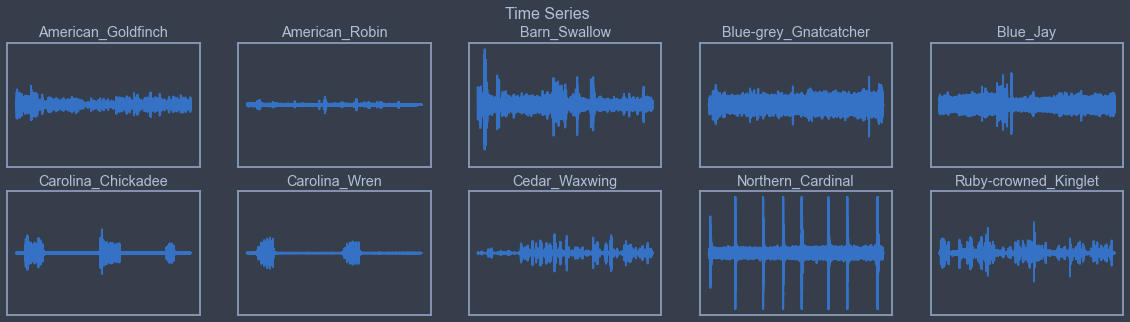

In [119]:
plot_signals(signals)

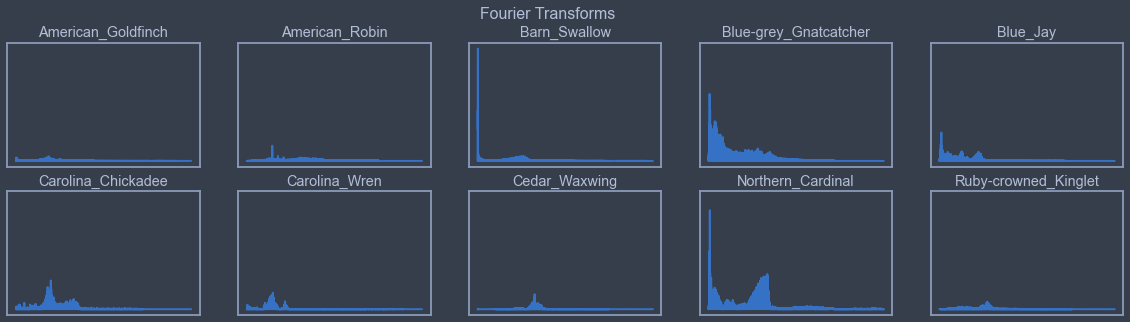

In [120]:
plot_fft(fft)

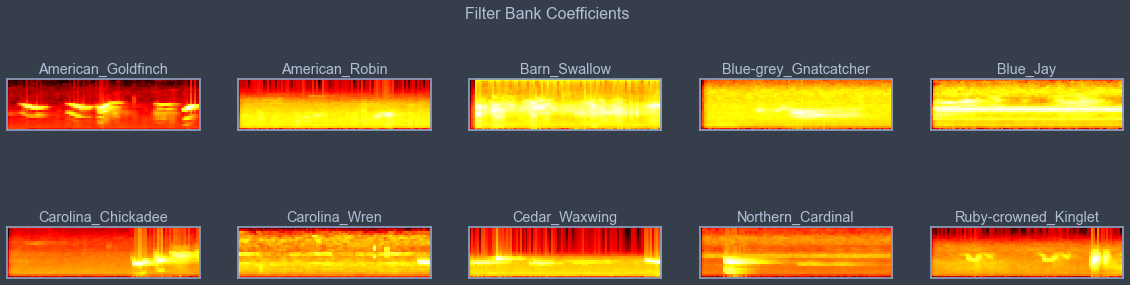

In [121]:
plot_fbank(fbank)

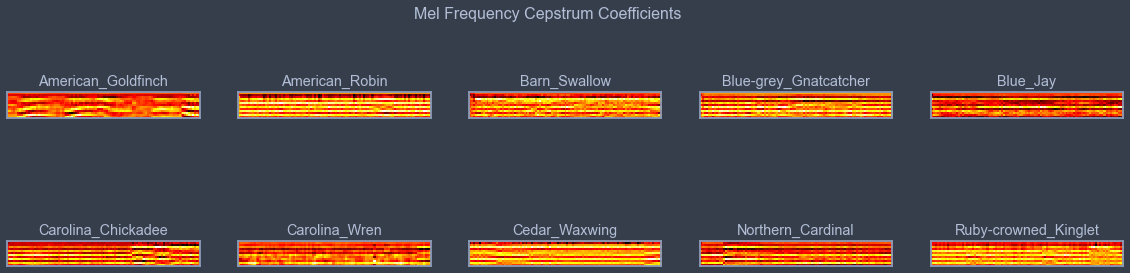

In [122]:
plot_mfccs(mfccs)

# noise threshold? envelope for the signal?

# use librosa for the Filter bank construction